In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.average(any_numbers)) / np.std(any_numbers)

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fit(t, x, y):
    """The fitted values along the regression line."""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b

def plot_residuals(t, x, y):
    """Plot a scatter diagram and residuals."""
    t.scatter(x, y, fit_line=True)
    actual = t.column(y)
    fitted = fit(t, x, y)
    residuals = actual - fitted
    print('r:', correlation(t, x, y))
    print('RMSE:', np.mean(residuals**2)**0.5)
    t.select(x).with_column('Residual', residuals).scatter(0, 1)

# Investigating the Regression Model 

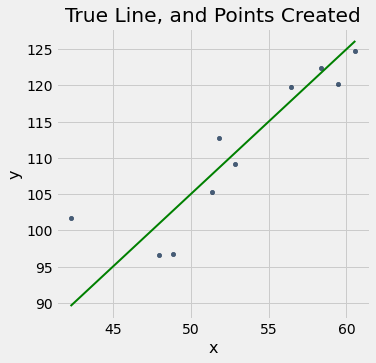

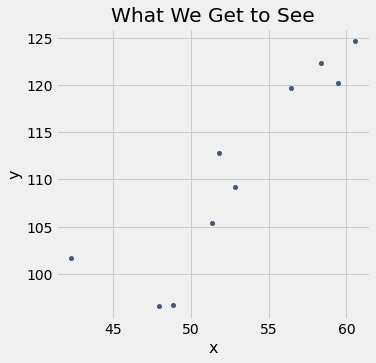

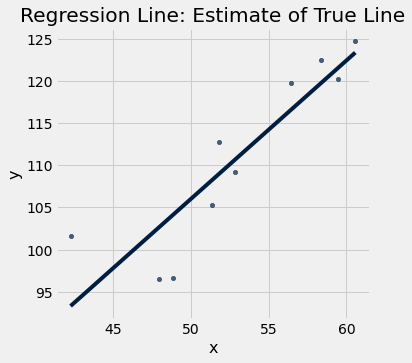

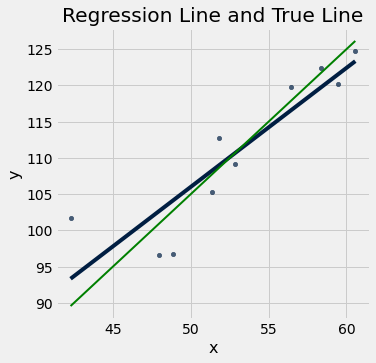

In [3]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)
    
    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')
    
    sample.scatter('x', 'y')
    plots.title('What We Get to See')
    
    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')
    
    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('Regression Line and True Line')
    
draw_and_compare(2, 5, 10)

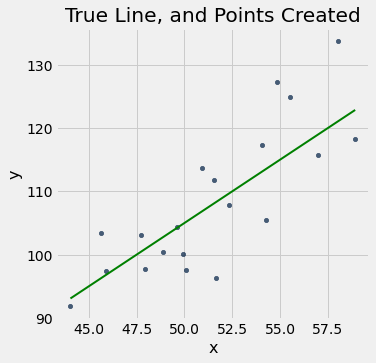

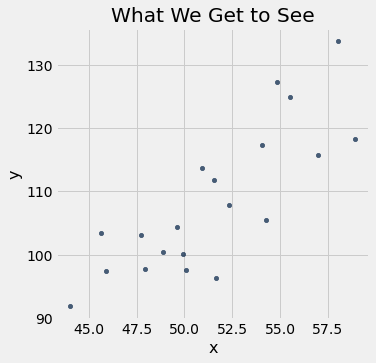

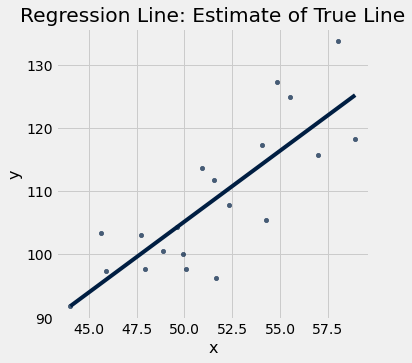

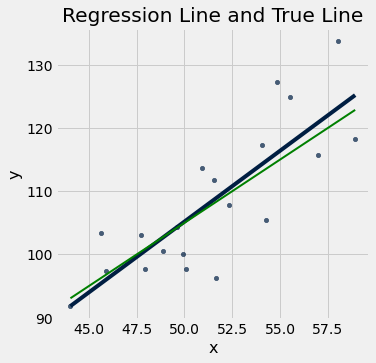

In [4]:
## let's try some different sample sizes 
draw_and_compare(2, 5, 20)

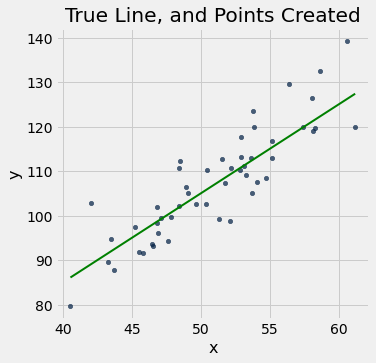

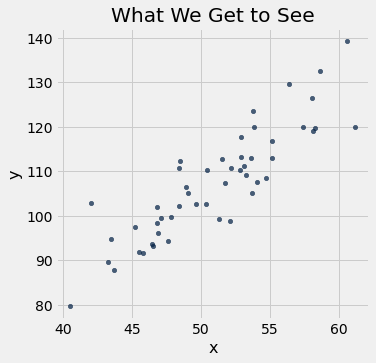

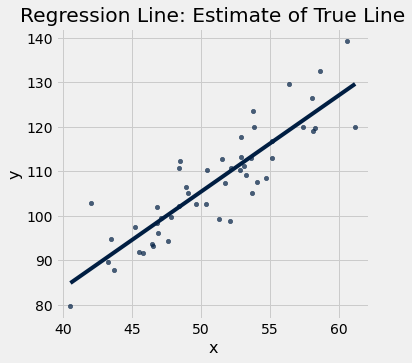

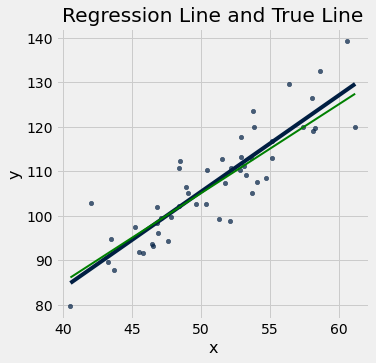

In [5]:
draw_and_compare(2, 5, 50)

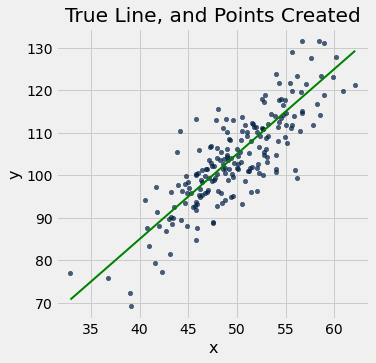

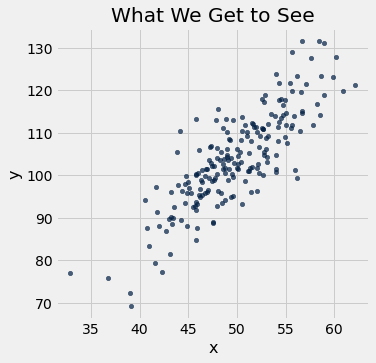

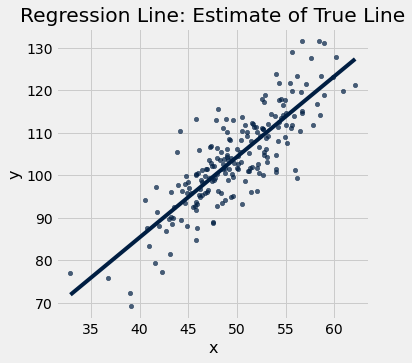

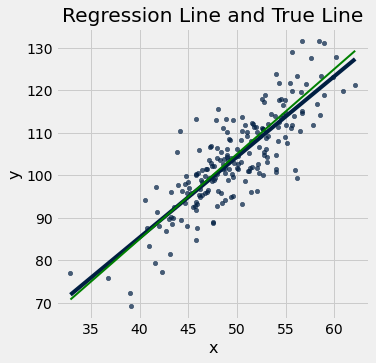

In [6]:
draw_and_compare(2, 5, 200)

# True Slope

In [7]:
neo = Table.read_table('neo.csv').select('H (mag)', 'V relative (km/s)')

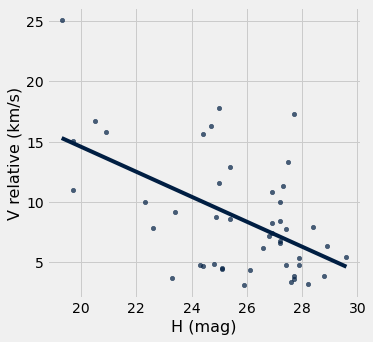

In [8]:
neo.scatter(0, 1, fit_line = True)

In [9]:
slope(neo, 0, 1)

-1.0339612033394248

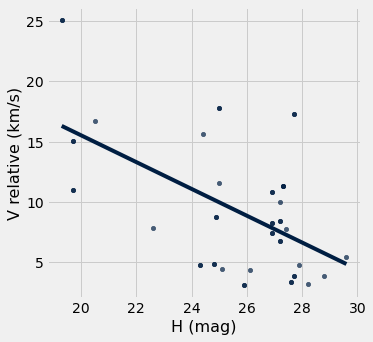

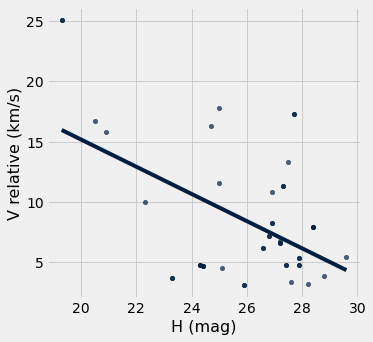

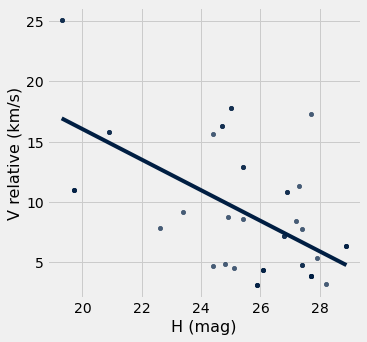

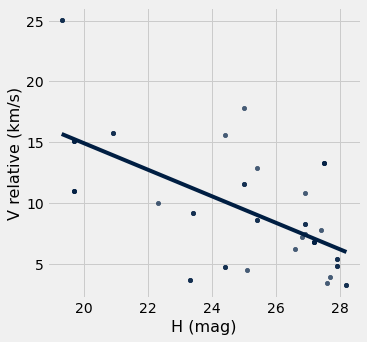

In [10]:
for i in np.arange(4):
    neo.sample().scatter(0, 1, fit_line = True)

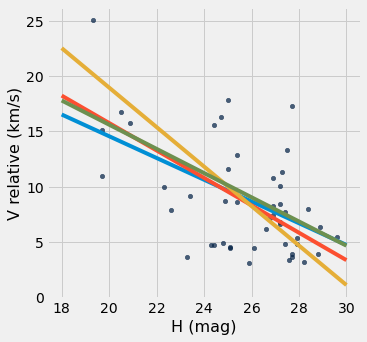

In [11]:
neo.scatter(0, 1)
for i in np.arange(4):
    resample = neo.sample()
    s = slope(resample, 0, 1)
    c = intercept(resample, 0, 1)
    xlims = make_array(18, 30)
    plots.plot(xlims, s*xlims + c, lw=4)

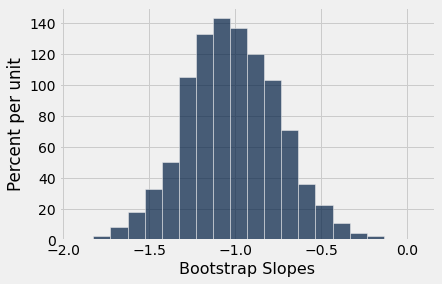

In [12]:
## bootstrap and ci
slopes = []

for i in np.arange(5000):
    
    ## resampel from our sample 
    resample = neo.sample()
    
    ## calculate the slope from new sample 
    resample_slope = slope(resample, 0, 1)
    
    ## add slope to our list of slopes
    slopes.append(resample_slope)
    
## histogram slopes 
Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)

In [13]:
left = percentile(2.5, slopes)
right = percentile(97.5, slopes)
[left, right]

[-1.5479536838915142, -0.46741228607963026]

Slope of regression line: -1.0339612033394248
Approximate 95%-confidence interval for the true slope:
-1.511728060863233 -0.46307924321360056


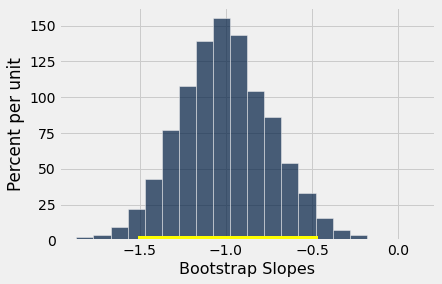

In [14]:
def bootstrap_slope(table, x, y, repetitions=5000):
    
    # Bootstrap resampling
    slopes = []
    for i in np.arange(repetitions):
        resample = table.sample()
        resample_slope = slope(resample, x, y)
        slopes.append(resample_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)
    
bootstrap_slope(neo, 0, 1)

# Prediction Variability

r: -0.5410653171907023
RMSE: 4.099126154456978


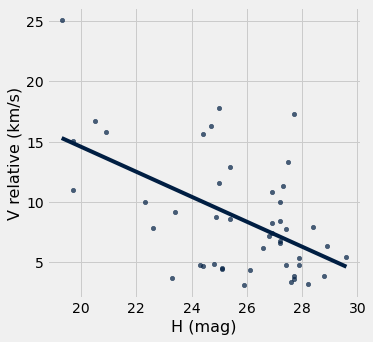

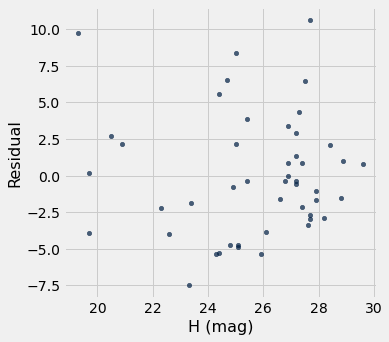

In [15]:
plot_residuals(neo, 0, 1)

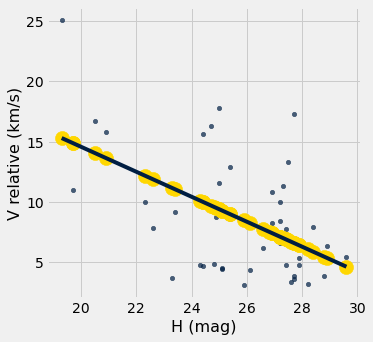

In [16]:
x = neo.column('H (mag)')
a = slope(neo, 0, 1)
b = intercept(neo, 0, 1)
predicted_y = a * x + b
neo.scatter(0, 1, fit_line=True)
plots.scatter(x, predicted_y, color='gold', s=200);

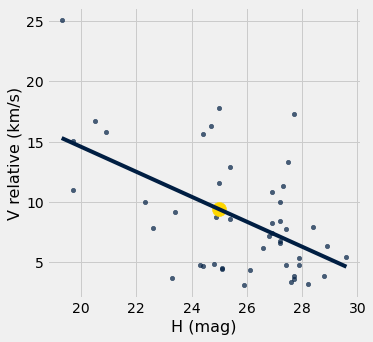

In [17]:
x = 25
a = slope(neo, 0, 1)
b = intercept(neo, 0, 1)
predicted_y = a * x + b
neo.scatter(0, 1, fit_line=True)
plots.scatter(x, predicted_y, color='gold', s=200);

In [18]:
predicted_y

9.403026217457803

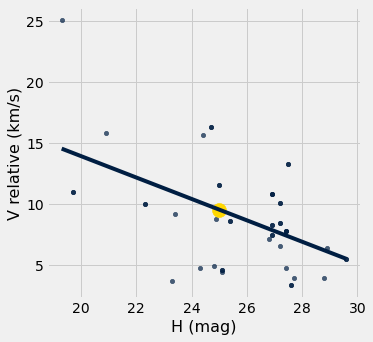

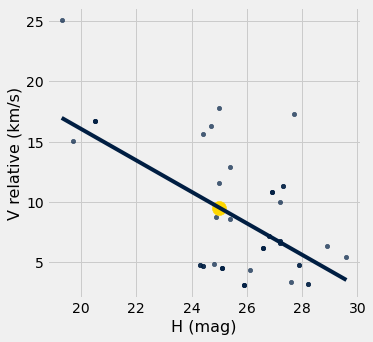

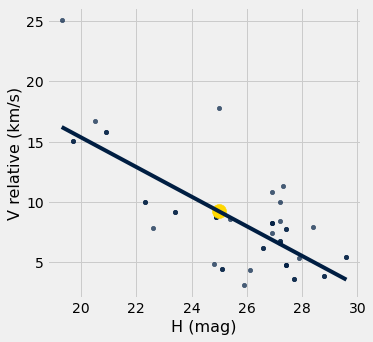

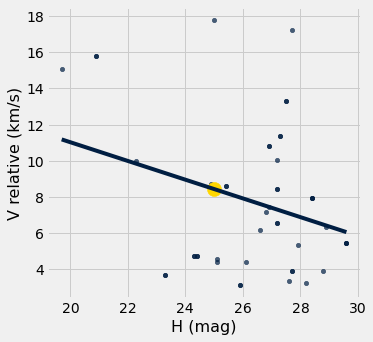

In [19]:
def prediction_at(t, x):
    a = slope(t, 0, 1)
    b = intercept(t, 0, 1)
    return a * x + b

for i in np.arange(4):
    resample = neo.sample()
    predicted_y = prediction_at(resample, x)
    resample.scatter(0, 1, fit_line=True)
    plots.scatter(x, predicted_y, color='gold', s=200)

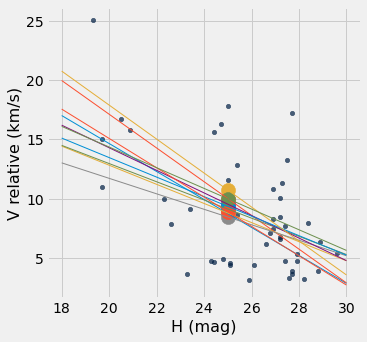

In [20]:
lines = Table(['slope', 'intercept', 'at 18', 'at 25', 'at 30'])

for i in range(10):
    resample = neo.sample()
    a = slope(resample, 0, 1)
    b = intercept(resample, 0, 1)
    lines.append([a, b, a * 18 + b, a * 25 + b, a * 30 + b])
    
neo.scatter(0, 1)
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([18, 30], [line.item('at 18'), line.item('at 30')], lw=1)
    plots.scatter(25, line.item('at 25'), s=200)

Approximate 95%-confidence interval for height of true line:
8.051775666213452 10.70258685095256 (width = 2.6508111847391085 )


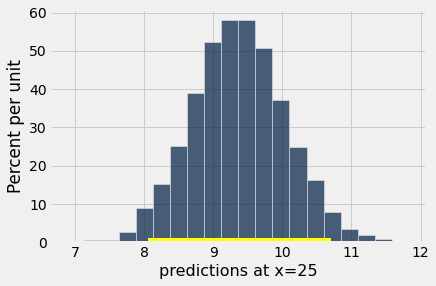

In [21]:
def bootstrap_prediction(table, x, y, new_x, repetitions=5000):

    # Bootstrap resampling
    predictions = []
    
    for i in np.arange(repetitions):
        ## resample from original sample table 
        resample = table.sample()
        ## calculate slope 
        a = slope(resample, x, y)
        ##calculate intercept 
        b = intercept(resample, x, y)
        ## predicted y value - estimate from regression line 
        predicted_y = a * new_x + b
        ## collect predictions in list 
        predictions.append(predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')')
    
bootstrap_prediction(neo, 0, 1, 25)

Approximate 95%-confidence interval for height of true line:
9.733339644858592 14.979703115358642 (width = 5.24636347050005 )


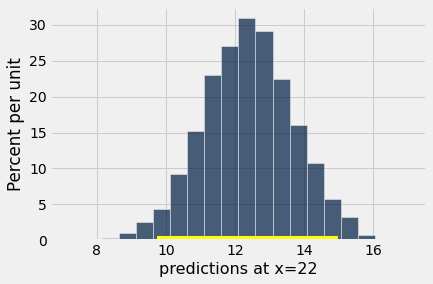

In [22]:
## try different new x values
bootstrap_prediction(neo, 0, 1, 22)

In [ ]:
bootstrap_prediction(neo, 0, 1, 27)

In [ ]:
bootstrap_prediction(neo, 0, 1, 20)